In [2]:
import scipy.io, os, torch
import numpy as np

from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

if os.getcwd()=='/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    file_loc = ('gdrive/MyDrive/colab/ex4data1.mat')
else:
    file_loc = 'ex4data1.mat'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mat = scipy.io.loadmat(file_loc)
X = mat['X']
y = mat['y']

#plt.imshow(img_out(X,0))
y_a = np.zeros((10,5000)).astype('int32')
y_temp = np.where(y==10,0,y)
for i in range(5000):
    y_a[y_temp[i],i] = 1
y_a = np.r_[y_a[1:,:], y_a[0,:].reshape(1,-1)].T
print(device)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
cuda


In [63]:
y.shape

(5000, 1)

In [61]:
X_a = X.reshape(-1,20,20, order='F')

X_b = torch.from_numpy(X_a.astype(np.float32)).to(device)
y_b = (torch.from_numpy(y.astype(np.float32))).view(-1,10).to(device)
dataset = TensorDataset(X_b, y_b)

test_ratio = 0.2  # 20% data split into test dataset
n_sample = X_a.shape[0]
test_size = int(n_sample * test_ratio)
train_size = n_sample - test_size
train_ds, test_ds = random_split(dataset,[train_size, test_size])
train_dataloader = DataLoader(train_ds, batch_size=train_size, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=test_size)
for X_C in train_dataloader:
    X_train = X_C[0].view(-1,1,20,20).to(device)
    y_train = X_C[1].to(device)
for X_D in test_dataloader:
    X_test = X_D[0].view(-1,1,20,20).to(device)
    y_test = X_D[1].to(device)

AssertionError: ignored

In [32]:
class CNN_model(nn.Module):
    def __init__(self,input_channel,classes):
        super(CNN_model,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channel, out_channels=20,kernel_size=(5, 5))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize second set of CONV => RELU => POOL layers
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize first (and only) set of FC => RELU layers
        self.fc1 = nn.Linear(in_features=200, out_features=50)
        self.relu3 = nn.ReLU()
        # initialize our softmax classifier
        self.fc2 = nn.Linear(in_features=50, out_features=classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self,x_val):
        z = self.conv1(x_val)
        z = self.relu1(z)
        z = self.maxpool1(z)
        z = self.conv2(z)
        z = self.relu2(z)
        z = self.maxpool2(z)
        z = torch.flatten(z,1)
        z = self.fc1(z)
        z = self.relu3(z)
        z = self.fc2(z)
        z = self.logSoftmax(z)
        return z

In [33]:
model = CNN_model(1,10).to(device)
loss = nn.NLLLoss()
epoch = int(1e5)

In [44]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
for i in range(epoch):
    out = model(X_train)
    J = loss(out,y_train)
    J.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i%100==0:
        print(f'Epoch number {i} : Loss = {J:.4f}, accuracy {(torch.argmax(out,dim=1)==y_train).sum().item()}')

Epoch number 0 : Loss = 2.2971, accuracy 0
Epoch number 100 : Loss = 0.1423, accuracy 408
Epoch number 200 : Loss = 0.0267, accuracy 410
Epoch number 300 : Loss = 0.0054, accuracy 410
Epoch number 400 : Loss = 0.0021, accuracy 410
Epoch number 500 : Loss = 0.0011, accuracy 410
Epoch number 600 : Loss = 0.0007, accuracy 410
Epoch number 700 : Loss = 0.0005, accuracy 410


KeyboardInterrupt: ignored

In [59]:
torch.argmax(out[0,:])

tensor(3, device='cuda:0')

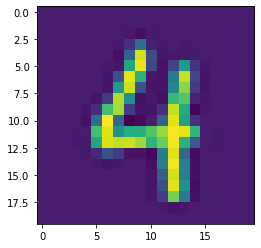

In [58]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0,0,:,:].detach().cpu().numpy())